## Mask R-CNN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory to hdd
DATA_DIR = os.path.abspath("/data/hdd")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.model as modellib
from mrcnn import data_generator
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.load_weights import load_weights

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATA_DIR, "russales", "test_logs")

# Local path to trained weights file
JUMP_MODEL_PATH = os.path.join(DATA_DIR, "russales", "logs", "jump20190617T1719", "mask_rcnn_jump_0160.h5")

Using TensorFlow backend.


In [2]:
# MS COCO Dataset
import jump
class InferenceConfig(jump.JumpConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
#    TRAINING_HEADS = "mask"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        25
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_LOSS_WEIGHTING        True
KEYPOINT_MASK_POOL_SIZE        14
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_keypoint_loss': 1.0, 

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
GPU_ID = "1"
DEVICE = "/gpu:{}".format(GPU_ID)  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [5]:
# Create model in inference mode
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, config=config, model_dir=MODEL_DIR)

# Load weights
print("Loading weights ", JUMP_MODEL_PATH)
load_weights(model, JUMP_MODEL_PATH, by_name=True, include_optimizer=False)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /data/hdd/russales/logs/jump20190617T1719/mask_rcnn_jump_0160.h5
Re-starting from epoch 160


## Review Weight Stats

In [6]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.6901,+0.7239,+0.1147
conv1/bias:0,"(64,)",-0.0012,+0.0003,+0.0003
bn_conv1/gamma:0,"(64,)",+0.5241,+2.6455,+0.4598
bn_conv1/beta:0,"(64,)",-2.6671,+6.2856,+1.8823
bn_conv1/moving_mean:0,"(64,)",-3.5374,+3.3343,+1.0033
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+184.1078,+83614.7344,+13554.5430
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.7387,+0.3914,+0.0751
res2a_branch2a/bias:0,"(64,)",-0.0071,+0.0047,+0.0024
bn2a_branch2a/gamma:0,"(64,)",+0.5049,+2.0656,+0.3752
bn2a_branch2a/beta:0,"(64,)",-2.4125,+3.5940,+1.1656


## Histograms of weights

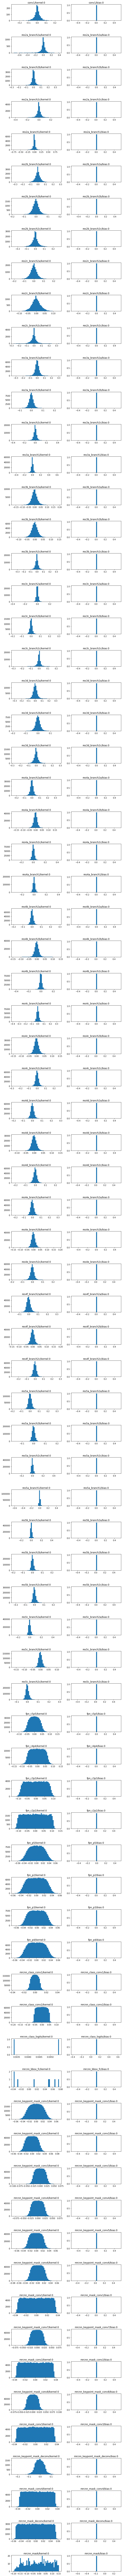

In [7]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
